In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import re
import json
from nltk.corpus import stopwords
import Utils.plot as plot_helper
import Utils.dataframe as dataframe_helper
import Utils.dict as dict_helper
import Utils.calculate as calculate

In [3]:
TOP_WORDS = 1000
N = 10
NUMBER_OF_SELECTED_WORDS = None

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [5]:
df = dataframe_helper.load_data()
df = dataframe_helper.data_cleaning(df)
df = df[['reviewContent', 'flagged']]
df['flagged'].replace({'Y': 'Fake', 'N':'Genuine'}, inplace=True)

fake_df = df[df['flagged'] == 'Fake'].reset_index(drop=True)
genuine_df = df[df['flagged'] == 'Genuine'].reset_index(drop=True)
all_df = pd.concat([fake_df, genuine_df]).reset_index(drop=True)

c:\Users\Um_25\Desktop\project\yelp-fake-reviews\Code\..\Utils\dataframe.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][i] = df['date'][i][1:]


In [6]:
# df = pd.read_csv('../Data/BBC/BBC_News_Train.csv')

# sport_df = df[df['Category'] == 'sport']
# sport_df.reset_index(drop=True, inplace=True)

# tech_df = df[df['Category'] == 'tech']
# tech_df.reset_index(drop=True, inplace=True)

# all_df = pd.concat([sport_df, tech_df])
# all_df.reset_index(drop=True, inplace=True)


In [7]:
text_string_fake = dataframe_helper.get_str_from_df(fake_df, 10, 'reviewContent')
text_string_genuine = dataframe_helper.get_str_from_df(genuine_df, 10, 'reviewContent')

In [8]:
# with open ('../Data/book/fake_book.txt', 'r', encoding='utf-8' ) as f:
#      text_string_fake = f.read().lower()

# with open ('../Data/book/genuine_book.txt', 'r', encoding='utf-8' ) as f:
#      text_string_genuine = f.read().lower()

# zipf distribution
- from zipf's law most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc.

    ![Zipf_distribution_CMF](../Picture/Zipf_distribution_CMF.png "Zipf_distribution_CMF") 
    
    Zipf_distribution_CMF

    ![Zipf_distribution_PMF](../Picture/Zipf_distribution_PMF.png "Zipf_distribution_PMF") 
    
    Zipf_distribution_PMF

In [9]:
dict_fake = dict_helper.get_most_frequent(text_string_fake, remove_stop_word=False)
dict_helper.print_most_frequent(dict_fake)

the: 6632: 1.0
food: 4933: 1.34
place: 3835: 1.73
great: 3714: 1.79
good: 3204: 2.07
service: 2521: 2.63
like: 2146: 3.09
one: 2006: 3.31
time: 1963: 3.38
restaurant: 1799: 3.69
would: 1791: 3.7
get: 1686: 3.93
back: 1631: 4.07
best: 1536: 4.32
really: 1532: 4.33
this: 1406: 4.72
love: 1363: 4.87
pizza: 1301: 5.1
they: 1209: 5.49
table: 1168: 5.68
chicago: 1164: 5.7
also: 1136: 5.84
wait: 1119: 5.93
menu: 1079: 6.15
even: 1065: 6.23
delicious: 1042: 6.36
always: 1042: 6.36
went: 1036: 6.4
well: 1018: 6.51
there: 1012: 6.55
nice: 988: 6.71
bar: 984: 6.74
ordered: 978: 6.78
try: 966: 6.87
night: 960: 6.91
experience: 952: 6.97
never: 951: 6.97
people: 950: 6.98
order: 934: 7.1
staff: 916: 7.24
first: 906: 7.32
amazing: 880: 7.54
got: 871: 7.61
dinner: 866: 7.66
could: 826: 8.03
eat: 823: 8.06
better: 820: 8.09
little: 806: 8.23
came: 799: 8.3
and: 790: 8.39
going: 789: 8.41
much: 777: 8.54
say: 765: 8.67
make: 761: 8.71
meal: 754: 8.8
you: 752: 8.82
that: 731: 9.07
atmosphere: 717: 9.25


In [10]:
dict_genuine = dict_helper.get_most_frequent(text_string_genuine, remove_stop_word=False)
dict_helper.print_most_frequent(dict_genuine)

the: 29310: 1.0
food: 16788: 1.75
good: 16034: 1.83
place: 14229: 2.06
great: 12016: 2.44
like: 10879: 2.69
one: 9155: 3.2
really: 8728: 3.36
get: 8022: 3.65
service: 7969: 3.68
time: 7573: 3.87
would: 7342: 3.99
back: 7142: 4.1
also: 6050: 4.84
this: 5618: 5.22
menu: 5528: 5.3
restaurant: 5477: 5.35
they: 5444: 5.38
delicious: 5333: 5.5
well: 5105: 5.74
best: 5072: 5.78
wait: 5025: 5.83
love: 5001: 5.86
table: 4964: 5.9
ordered: 4963: 5.91
little: 4953: 5.92
and: 4852: 6.04
even: 4820: 6.08
there: 4780: 6.13
chicago: 4752: 6.17
try: 4633: 6.33
got: 4531: 6.47
pizza: 4512: 6.5
cheese: 4412: 6.64
much: 4364: 6.72
nice: 4331: 6.77
night: 4256: 6.89
that: 4173: 7.02
order: 4170: 7.03
bar: 4164: 7.04
dinner: 4119: 7.12
went: 4090: 7.17
could: 3909: 7.5
meal: 3897: 7.52
first: 3895: 7.53
experience: 3886: 7.54
came: 3866: 7.58
pretty: 3860: 7.59
you: 3823: 7.67
think: 3813: 7.69
people: 3806: 7.7
definitely: 3772: 7.77
dish: 3769: 7.78
amazing: 3697: 7.93
always: 3619: 8.1
but: 3579: 8.19
w

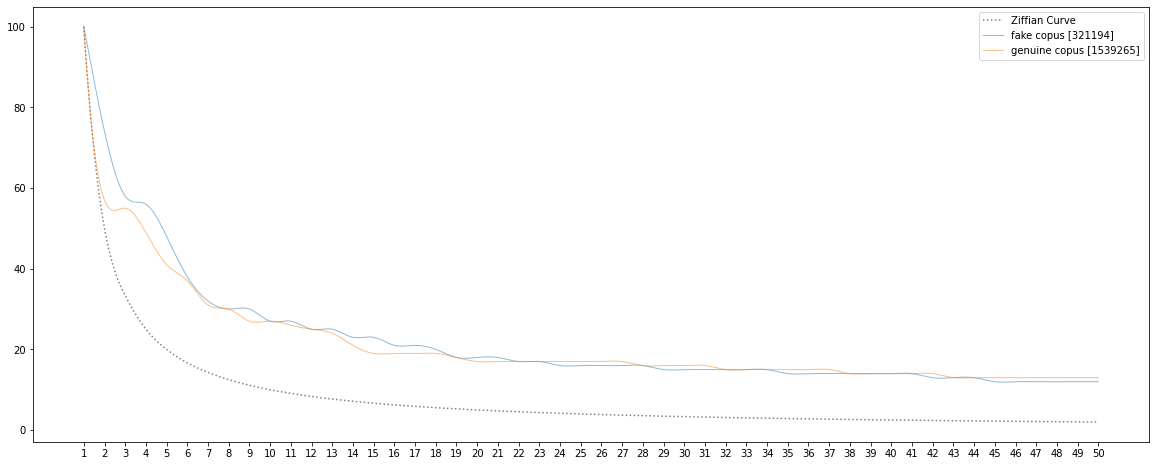

In [11]:
combined_dict = {'fake copus':dict_fake, 'genuine copus':dict_genuine}
plot_helper.zipf_plot(combined_dict, 50, 20, 8)

In [12]:
# with stop words
common_keys = dict_fake.keys() & dict_genuine.keys()
common_dict_fake = {key: dict_fake[key] for key in common_keys}
common_dict_fake = dict(sorted(common_dict_fake.items(), key=lambda elem: elem[1], reverse=True))
common_dict_genuine = {key: dict_genuine[key] for key in common_dict_fake.keys()}

# with stop words
sum_fake = sum(list(common_dict_fake.values()))
sum_genuine = sum(list(common_dict_genuine.values()))

# with stop words
words_list = list(common_dict_fake.keys())[:NUMBER_OF_SELECTED_WORDS]
prob_common_dict_fake = [x/sum_fake for x in list(common_dict_fake.values())[:NUMBER_OF_SELECTED_WORDS]]
prob_common_dict_genuine = [x/sum_genuine for x in list(common_dict_genuine.values())[:NUMBER_OF_SELECTED_WORDS]]

In [13]:
# calculate the kl divergence
kl_pq = calculate.kl_divergence(prob_common_dict_fake, prob_common_dict_genuine)
print('KL(P || Q): %.3f bits' % kl_pq)
kl_qp = calculate.kl_divergence(prob_common_dict_genuine, prob_common_dict_fake)
print('KL(Q || P): %.3f bits' % kl_qp)

delta_words = calculate.delta_kl_divergence_list(prob_common_dict_fake, prob_common_dict_genuine)

positive_deltas = [x for x in delta_words if x >= 0]
positive_indexs = [i for i,x in enumerate(delta_words) if x >= 0]
positive_words = [words_list[i] for i in positive_indexs]

negative_deltas = [x for x in delta_words if x < 0]
negative_indexs = [i for i,x in enumerate(delta_words) if x < 0]
negative_words = [words_list[i] for i in negative_indexs]

KL(P || Q): 0.102 bits
KL(Q || P): 0.107 bits


In [14]:
dict_helper.print_word_and_delta(positive_words, positive_deltas)

word: delta_KL
the: 0.0035724668314567895
food: 0.012445980247048828
place: 0.007352024633940279
great: 0.010615735564728862
service: 0.007582727917957305
one: 0.0005210880623106197
time: 0.0031966678080856217
restaurant: 0.005836283477436548
would: 0.0020749346209564326
back: 0.0010065240247189677
best: 0.004184920086564339
this: 0.0019120272705848915
love: 0.002723134614829297
pizza: 0.0031149055006918485
they: 0.0004563407497252025
table: 0.0010121518340106858
chicago: 0.0013867447765508474
wait: 0.00044891958685794157
even: 0.0003548091681252031
always: 0.0024844228458304287
went: 0.0015053353674425794
nice: 0.0006007457302239681
bar: 0.0008875632410873528
night: 0.0004914170511768531
experience: 0.0011351768743427303
never: 0.0023406874354727257
people: 0.0012723594283056685
order: 0.00042153874723825234
staff: 0.0038019789540378844
first: 0.0006989642640620306
amazing: 0.00084587349439164
eat: 0.0013344224886171728
better: 0.0013479335313183595
going: 0.0013333904105941774
say: 0

In [15]:
dict_helper.print_comporison(positive_words, common_dict_fake, common_dict_genuine)

the:fake -> 0.020857247988024064, genuine -> 0.019619511339622375 : fake
food:fake -> 0.015513993414493775, genuine -> 0.011237542011927002 : fake
place:fake -> 0.012060848316355894, genuine -> 0.009524600029051068 : fake
great:fake -> 0.011680310468564744, genuine -> 0.00804326333186293 : fake
service:fake -> 0.007928395985797447, genuine -> 0.005334284744641785 : fake
one:fake -> 0.006308751427016929, genuine -> 0.006128168758588975 : fake
time:fake -> 0.006173518968710983, genuine -> 0.005069210487033786 : fake
restaurant:fake -> 0.005657748662613886, genuine -> 0.0036661911841389203 : fake
would:fake -> 0.005632589135487198, genuine -> 0.004914583836762453 : fake
back:fake -> 0.005129398592953445, genuine -> 0.004780707949081645 : fake
best:fake -> 0.004830629208324029, genuine -> 0.0033950925115852847 : fake
this:fake -> 0.0044217868925153555, genuine -> 0.0037605736849538897 : fake
love:fake -> 0.0042865544342094095, genuine -> 0.003347566571458598 : fake
pizza:fake -> 0.00409156

In [16]:
dict_helper.print_word_and_delta(negative_words, negative_deltas)

word: delta_KL
good: -0.0018947121072740048
like: -0.0015390455687661077
get: -0.00019445338767849668
really: -0.0029646344868511612
also: -0.00137840059101143
menu: -0.000886190088111238
delicious: -0.0008452772504135931
well: -0.0006224032969638138
there: -4.891767404151032e-05
ordered: -0.0007112482514807989
try: -0.00018242668908447266
got: -0.0008482141147236057
dinner: -9.710929884792391e-05
could: -5.4485200164316414e-05
little: -0.0022658877841628964
came: -0.00021645776822164768
and: -0.002215650955862552
much: -0.0013815830070189577
meal: -0.0006851822337337667
you: -0.0005601770773183039
that: -0.0014309531740132049
definitely: -0.0008800158541053242
know: -5.981817437131671e-05
two: -0.00017706330193840454
wine: -0.0009302870833189016
made: -8.985725225391927e-05
salad: -0.0005357610460782011
think: -0.0014262228918383924
but: -0.0011534969453772803
come: -9.555315150881283e-05
everything: -0.0004662017503694469
chicken: -0.0003795437093541352
cheese: -0.003176162177527278


In [17]:
dict_helper.print_comporison(negative_words, common_dict_fake, common_dict_genuine)

good:fake -> 0.010076390614238406, genuine -> 0.010732829915370357 : genuine
like:fake -> 0.006749043151733963, genuine -> 0.007282178910397538 : genuine
get:fake -> 0.0053023703419494235, genuine -> 0.005369761854877199 : genuine
really:fake -> 0.004818049444760685, genuine -> 0.00584234373839045 : genuine
also:fake -> 0.0035726528519896467, genuine -> 0.004049745602344434 : genuine
menu:fake -> 0.0033933912212119974, genuine -> 0.003700329535497526 : genuine
delicious:fake -> 0.003277028408251067, genuine -> 0.003569800545008739 : genuine
well:fake -> 0.003201549826871004, genuine -> 0.003417182033052618 : genuine
there:fake -> 0.003182680181525988, genuine -> 0.0031996337155713052 : genuine
ordered:fake -> 0.003075752191237566, genuine -> 0.0033221301527992446 : genuine
try:fake -> 0.003038012900547534, genuine -> 0.0031012349381259116 : genuine
got:fake -> 0.0027392435159181183, genuine -> 0.0030329582354086996 : genuine
dinner:fake -> 0.0027235188114639384, genuine -> 0.0027571739

In [18]:
delta_words_dict = {words_list[i]: delta_words[i] for i in range(len(delta_words))}
delta_words_dict = dict(sorted(delta_words_dict.items(), key=lambda elem: elem[1], reverse=True))

In [19]:
delta_words_dict

{'food': 0.012445980247048828,
 'great': 0.010615735564728862,
 'service': 0.007582727917957305,
 'place': 0.007352024633940279,
 'restaurant': 0.005836283477436548,
 'best': 0.004184920086564339,
 'staff': 0.0038019789540378844,
 'the': 0.0035724668314567895,
 'owner': 0.0035381150825622236,
 'time': 0.0031966678080856217,
 'pizza': 0.0031149055006918485,
 'love': 0.002723134614829297,
 'manager': 0.002548703257119415,
 'always': 0.0024844228458304287,
 'never': 0.0023406874354727257,
 'would': 0.0020749346209564326,
 'this': 0.0019120272705848915,
 'atmosphere': 0.0018449857733749333,
 'told': 0.0018218781885900855,
 'simply': 0.0017355330362662808,
 'sushi': 0.0016869139869095096,
 'asked': 0.001658934092674591,
 'went': 0.0015053353674425794,
 'customer': 0.00150185671188394,
 'recommend': 0.0014934616855922667,
 'waiter': 0.001448205213107703,
 'friends': 0.0014017093937281956,
 'chicago': 0.0013867447765508474,
 'family': 0.0013832603885216847,
 'rude': 0.0013678816739917284,
 'b

P=1.000 Q=1.000


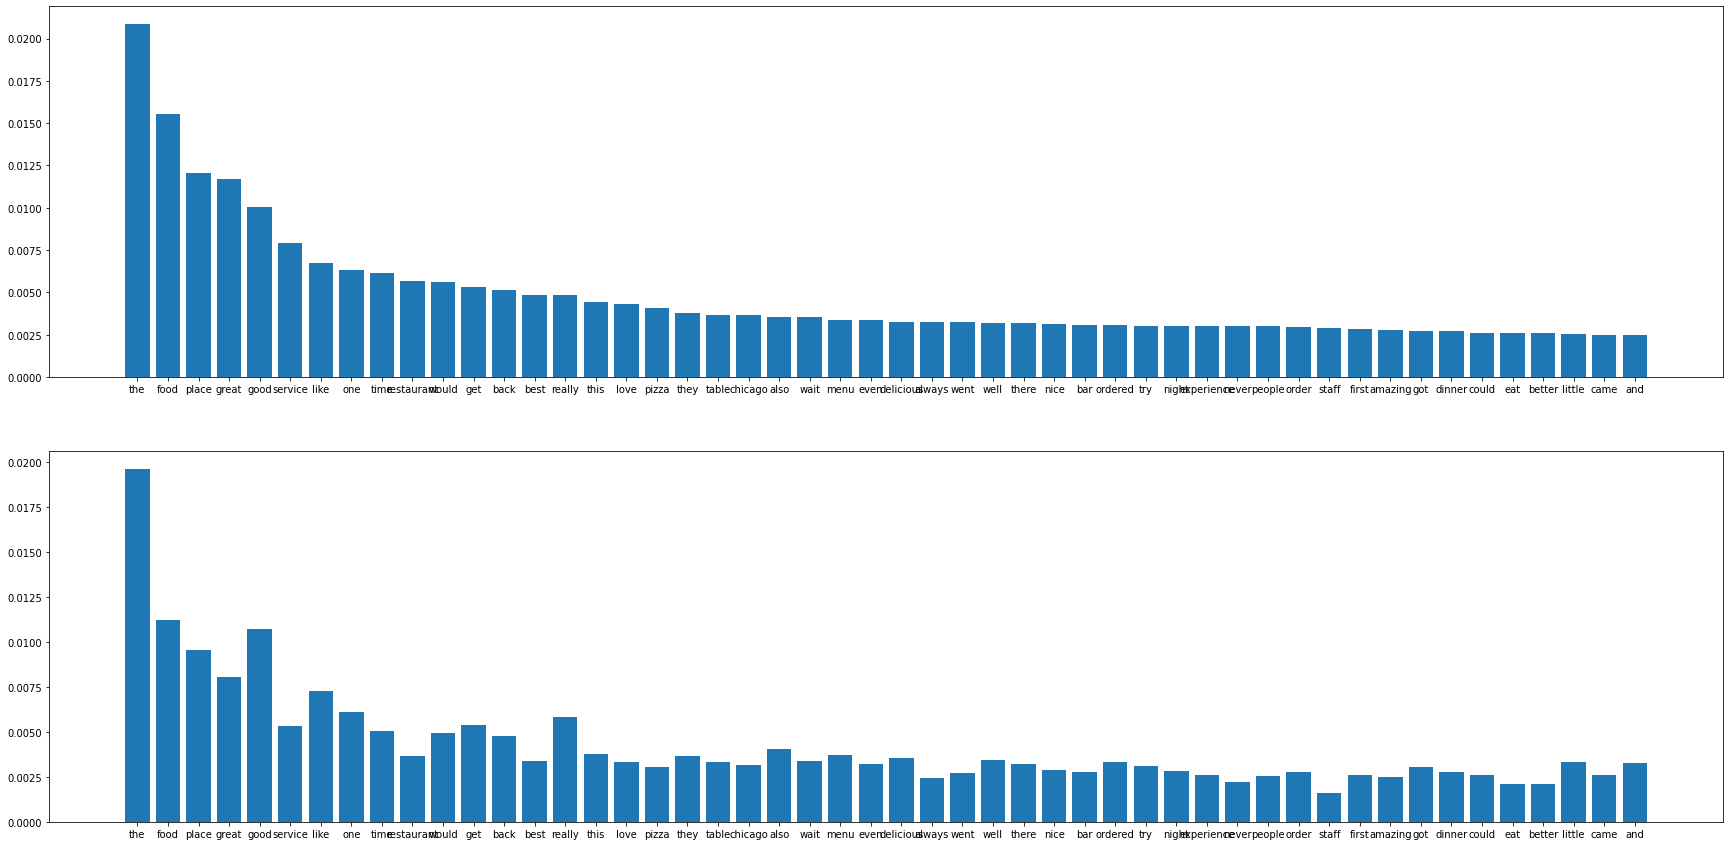

In [20]:
plot_helper.plot_words_distribution(prob_common_dict_fake, prob_common_dict_genuine, words_list, 30, 15, 50)

In [21]:
abs_delta_words_dict = {words_list[i]: abs(delta_words[i]) for i in range(len(delta_words))}
abs_delta_words_dict = dict(sorted(abs_delta_words_dict.items(), key=lambda elem: elem[1], reverse=True))

top_words = list(abs_delta_words_dict.keys())[:TOP_WORDS]

In [22]:
for i in top_words:
    print(f'{i}: {delta_words_dict[i]}')

food: 0.012445980247048828
great: 0.010615735564728862
service: 0.007582727917957305
place: 0.007352024633940279
restaurant: 0.005836283477436548
best: 0.004184920086564339
staff: 0.0038019789540378844
the: 0.0035724668314567895
owner: 0.0035381150825622236
pork: -0.0034869132666983426
time: 0.0031966678080856217
cheese: -0.003176162177527278
pizza: 0.0031149055006918485
really: -0.0029646344868511612
alinea: -0.002810448585952549
love: 0.002723134614829297
manager: 0.002548703257119415
always: 0.0024844228458304287
pretty: -0.0023459579383425487
never: 0.0023406874354727257
little: -0.0022658877841628964
and: -0.002215650955862552
dish: -0.0020807723007612994
would: 0.0020749346209564326
sauce: -0.00200247897398043
sweet: -0.0019895289378723847
publican: -0.001979189681381923
this: 0.0019120272705848915
good: -0.0018947121072740048
atmosphere: 0.0018449857733749333
told: 0.0018218781885900855
chocolate: -0.001772443231756946
simply: 0.0017355330362662808
sushi: 0.0016869139869095096
p

In [23]:
top_words_fake = {i:delta_words_dict[i] for i in top_words if delta_words_dict[i] > 0}
top_words_genuine = {i:delta_words_dict[i] for i in top_words if delta_words_dict[i] < 0}

In [50]:
top_words = {i:delta_words_dict[i] for i in top_words}

In [51]:
top_words

{'food': 0.012445980247048828,
 'great': 0.010615735564728862,
 'service': 0.007582727917957305,
 'place': 0.007352024633940279,
 'restaurant': 0.005836283477436548,
 'best': 0.004184920086564339,
 'staff': 0.0038019789540378844,
 'the': 0.0035724668314567895,
 'owner': 0.0035381150825622236,
 'pork': -0.0034869132666983426,
 'time': 0.0031966678080856217,
 'cheese': -0.003176162177527278,
 'pizza': 0.0031149055006918485,
 'really': -0.0029646344868511612,
 'alinea': -0.002810448585952549,
 'love': 0.002723134614829297,
 'manager': 0.002548703257119415,
 'always': 0.0024844228458304287,
 'pretty': -0.0023459579383425487,
 'never': 0.0023406874354727257,
 'little': -0.0022658877841628964,
 'and': -0.002215650955862552,
 'dish': -0.0020807723007612994,
 'would': 0.0020749346209564326,
 'sauce': -0.00200247897398043,
 'sweet': -0.0019895289378723847,
 'publican': -0.001979189681381923,
 'this': 0.0019120272705848915,
 'good': -0.0018947121072740048,
 'atmosphere': 0.0018449857733749333,
 

In [24]:
top_words_fake

{'food': 0.012445980247048828,
 'great': 0.010615735564728862,
 'service': 0.007582727917957305,
 'place': 0.007352024633940279,
 'restaurant': 0.005836283477436548,
 'best': 0.004184920086564339,
 'staff': 0.0038019789540378844,
 'the': 0.0035724668314567895,
 'owner': 0.0035381150825622236,
 'time': 0.0031966678080856217,
 'pizza': 0.0031149055006918485,
 'love': 0.002723134614829297,
 'manager': 0.002548703257119415,
 'always': 0.0024844228458304287,
 'never': 0.0023406874354727257,
 'would': 0.0020749346209564326,
 'this': 0.0019120272705848915,
 'atmosphere': 0.0018449857733749333,
 'told': 0.0018218781885900855,
 'simply': 0.0017355330362662808,
 'sushi': 0.0016869139869095096,
 'asked': 0.001658934092674591,
 'went': 0.0015053353674425794,
 'customer': 0.00150185671188394,
 'recommend': 0.0014934616855922667,
 'waiter': 0.001448205213107703,
 'friends': 0.0014017093937281956,
 'chicago': 0.0013867447765508474,
 'family': 0.0013832603885216847,
 'rude': 0.0013678816739917284,
 'b

In [25]:
top_words_genuine

{'pork': -0.0034869132666983426,
 'cheese': -0.003176162177527278,
 'really': -0.0029646344868511612,
 'alinea': -0.002810448585952549,
 'pretty': -0.0023459579383425487,
 'little': -0.0022658877841628964,
 'and': -0.002215650955862552,
 'dish': -0.0020807723007612994,
 'sauce': -0.00200247897398043,
 'sweet': -0.0019895289378723847,
 'publican': -0.001979189681381923,
 'good': -0.0018947121072740048,
 'chocolate': -0.001772443231756946,
 'pig': -0.0016763507309660137,
 'sandwich': -0.0016209762468726912,
 'tasty': -0.0015575418860452803,
 'though': -0.0015457479775654941,
 'like': -0.0015390455687661077,
 'bacon': -0.001511122440405844,
 'duck': -0.0015039910219826185,
 'here': -0.0014566899703286344,
 'beer': -0.0014413089224074704,
 'that': -0.0014309531740132049,
 'falafel': -0.0014295806822636602,
 'think': -0.0014262228918383924,
 'bit': -0.001417957541200067,
 'fried': -0.0013897301268236241,
 'much': -0.0013815830070189577,
 'also': -0.00137840059101143,
 'potato': -0.001340763

In [26]:
stop = stopwords.words('english')

In [53]:
pure_top_words = {i[0]:i[1] for i in top_words.items() if i[0] not in stop}
pure_top_words

{'food': 0.012445980247048828,
 'great': 0.010615735564728862,
 'service': 0.007582727917957305,
 'place': 0.007352024633940279,
 'restaurant': 0.005836283477436548,
 'best': 0.004184920086564339,
 'staff': 0.0038019789540378844,
 'owner': 0.0035381150825622236,
 'pork': -0.0034869132666983426,
 'time': 0.0031966678080856217,
 'cheese': -0.003176162177527278,
 'pizza': 0.0031149055006918485,
 'really': -0.0029646344868511612,
 'alinea': -0.002810448585952549,
 'love': 0.002723134614829297,
 'manager': 0.002548703257119415,
 'always': 0.0024844228458304287,
 'pretty': -0.0023459579383425487,
 'never': 0.0023406874354727257,
 'little': -0.0022658877841628964,
 'dish': -0.0020807723007612994,
 'would': 0.0020749346209564326,
 'sauce': -0.00200247897398043,
 'sweet': -0.0019895289378723847,
 'publican': -0.001979189681381923,
 'good': -0.0018947121072740048,
 'atmosphere': 0.0018449857733749333,
 'told': 0.0018218781885900855,
 'chocolate': -0.001772443231756946,
 'simply': 0.0017355330362

In [27]:
pure_top_words_fake = {i[0]:i[1] for i in top_words_fake.items() if i[0] not in stop}
pure_top_words_fake

{'food': 0.012445980247048828,
 'great': 0.010615735564728862,
 'service': 0.007582727917957305,
 'place': 0.007352024633940279,
 'restaurant': 0.005836283477436548,
 'best': 0.004184920086564339,
 'staff': 0.0038019789540378844,
 'owner': 0.0035381150825622236,
 'time': 0.0031966678080856217,
 'pizza': 0.0031149055006918485,
 'love': 0.002723134614829297,
 'manager': 0.002548703257119415,
 'always': 0.0024844228458304287,
 'never': 0.0023406874354727257,
 'would': 0.0020749346209564326,
 'atmosphere': 0.0018449857733749333,
 'told': 0.0018218781885900855,
 'simply': 0.0017355330362662808,
 'sushi': 0.0016869139869095096,
 'asked': 0.001658934092674591,
 'went': 0.0015053353674425794,
 'customer': 0.00150185671188394,
 'recommend': 0.0014934616855922667,
 'waiter': 0.001448205213107703,
 'friends': 0.0014017093937281956,
 'chicago': 0.0013867447765508474,
 'family': 0.0013832603885216847,
 'rude': 0.0013678816739917284,
 'better': 0.0013479335313183595,
 'wonderful': 0.0013443157487362

In [28]:
pure_top_words_genuine = {i[0]:i[1] for i in top_words_genuine.items()  if i[0] not in stop}
pure_top_words_genuine

{'pork': -0.0034869132666983426,
 'cheese': -0.003176162177527278,
 'really': -0.0029646344868511612,
 'alinea': -0.002810448585952549,
 'pretty': -0.0023459579383425487,
 'little': -0.0022658877841628964,
 'dish': -0.0020807723007612994,
 'sauce': -0.00200247897398043,
 'sweet': -0.0019895289378723847,
 'publican': -0.001979189681381923,
 'good': -0.0018947121072740048,
 'chocolate': -0.001772443231756946,
 'pig': -0.0016763507309660137,
 'sandwich': -0.0016209762468726912,
 'tasty': -0.0015575418860452803,
 'though': -0.0015457479775654941,
 'like': -0.0015390455687661077,
 'bacon': -0.001511122440405844,
 'duck': -0.0015039910219826185,
 'beer': -0.0014413089224074704,
 'falafel': -0.0014295806822636602,
 'think': -0.0014262228918383924,
 'bit': -0.001417957541200067,
 'fried': -0.0013897301268236241,
 'much': -0.0013815830070189577,
 'also': -0.00137840059101143,
 'potato': -0.0013407636280750295,
 'bread': -0.0013367509181832736,
 'vegetarian': -0.0012779582230494383,
 'egg': -0.0

In [29]:
pure_top_n_words_fake = [i[0] for i in list(pure_top_words_fake.items())[:N]]
pure_top_n_words_genuine = [i[0] for i in list(pure_top_words_genuine.items())[:N]]

In [30]:
with open(f"../Data/top_word/top{N}_fake_word.txt", "w") as output:
    output.write(str(pure_top_n_words_fake ))

In [31]:
with open(f"../Data/top_word/top{N}_genuine_word.txt", "w") as output:
    output.write(str(pure_top_n_words_genuine ))

In [32]:
print(len(pure_top_words_fake.items()), len(pure_top_words_genuine.items()))

394 571


In [33]:
with open(f"../Data/top_word/top_fake_word.txt", "w") as output:
    output.write(str([i[0] for i in pure_top_words_fake.items()]))

In [34]:
with open(f"../Data/top_word/top_genuine_word.txt", "w") as output:
    output.write(str([i[0] for i in pure_top_words_genuine.items()]))

In [35]:
calculate.print_summary_kl('cup', common_dict_fake, common_dict_genuine)

# of word in document1: 317971 in document2: 1493921
# of word "cup" in document1: 55 in document2: 340
P of word "cup" in document1: 0.00017297174899597763 in document2: 0.00022758900905737317
---------------------------------
KL-divergence = P * log2(P/Q)
---------------------------------
KL-divergence for document1: -6.847855745530389e-05
KL-divergence for document2: 9.010122822596548e-05
delta KL-divergence for document1 and document2: -0.00015857978568126937


In [47]:
pure_top_words_genuine

{'pork': -0.0034869132666983426,
 'cheese': -0.003176162177527278,
 'really': -0.0029646344868511612,
 'alinea': -0.002810448585952549,
 'pretty': -0.0023459579383425487,
 'little': -0.0022658877841628964,
 'dish': -0.0020807723007612994,
 'sauce': -0.00200247897398043,
 'sweet': -0.0019895289378723847,
 'publican': -0.001979189681381923,
 'good': -0.0018947121072740048,
 'chocolate': -0.001772443231756946,
 'pig': -0.0016763507309660137,
 'sandwich': -0.0016209762468726912,
 'tasty': -0.0015575418860452803,
 'though': -0.0015457479775654941,
 'like': -0.0015390455687661077,
 'bacon': -0.001511122440405844,
 'duck': -0.0015039910219826185,
 'beer': -0.0014413089224074704,
 'falafel': -0.0014295806822636602,
 'think': -0.0014262228918383924,
 'bit': -0.001417957541200067,
 'fried': -0.0013897301268236241,
 'much': -0.0013815830070189577,
 'also': -0.00137840059101143,
 'potato': -0.0013407636280750295,
 'bread': -0.0013367509181832736,
 'vegetarian': -0.0012779582230494383,
 'egg': -0.0

In [54]:
def dict_to_df(dict):
    df = pd.DataFrame.from_dict(dict, orient='index')
    df = df.reset_index()
    df.columns = ['word', 'delta']
    return df

In [57]:
dict_to_df(pure_top_words).head(50)

,word,delta
0,food,0.012446
1,great,0.010616
2,service,0.007583
3,place,0.007352
4,restaurant,0.005836
5,best,0.004185
6,staff,0.003802
7,owner,0.003538
8,pork,-0.003487
9,time,0.003197


# TF-IDF Approch

In [36]:
def tfid(bagOfWordsA, bagOfWordsB, ngram: int=1):
    uniqueWords = set(bagOfWordsA).union(set(bagOfWordsB))

    numOfWordsA = dict.fromkeys(uniqueWords, 0)
    for word in bagOfWordsA:
        numOfWordsA[word] += 1
    numOfWordsB = dict.fromkeys(uniqueWords, 0)
    for word in bagOfWordsB:
        numOfWordsB[word] += 1
        
    tfA = calculate.computeTF(numOfWordsA, bagOfWordsA)
    tfB = calculate.computeTF(numOfWordsB, bagOfWordsB)

    idfs = calculate.computeIDF(uniqueWords, all_df, 'reviewContent', ngram=ngram)

    # with open("../Data/tfidf/idfs.json", "r") as json_file:
    #     idfs = json.load(json_file)

    tfidfA = calculate.computeTFIDF(tfA, idfs)
    tfidfB = calculate.computeTFIDF(tfB, idfs)
    df = pd.DataFrame([tfidfA, tfidfB])
    df.index = ['fake', 'genuine']
    tfidf = df.T

    return tfidf, tfA, tfB, idfs

In [37]:
bagOfWordsA = re.findall(r'\b[A-Za-z][a-z]{2,9}\b',  text_string_fake)
bagOfWordsB = re.findall(r'\b[A-Za-z][a-z]{2,9}\b',  text_string_genuine)

tfidf, tfA, tfB, idfs = tfid(bagOfWordsA, bagOfWordsB)

In [38]:
tfidf.loc[(tfidf['fake'] != 0) | (tfidf['genuine'] != 0)].sort_values(by='fake', ascending=False).head(10)

,fake,genuine
great,0.010869,0.007338
the,0.010072,0.009288
food,0.010012,0.007110
pizza,0.009799,0.007091
place,0.009625,0.007452
restaurant,0.009107,0.005786
service,0.008923,0.005886
time,0.008320,0.006697
good,0.008306,0.008673
would,0.007966,0.006814


In [39]:
tfidf.loc[(tfidf['fake'] != 0) | (tfidf['genuine'] != 0)].sort_values(by='genuine', ascending=False).head(10)

,fake,genuine
the,0.010072,0.009288
good,0.008306,0.008673
like,0.007753,0.008201
really,0.006488,0.007713
one,0.007879,0.007503
place,0.009625,0.007452
great,0.010869,0.007338
food,0.010012,0.007110
pizza,0.009799,0.007091
get,0.007017,0.006967


In [40]:
calculate.print_summary_tf_idf('married', tfA, tfB, idfs)

# of word in document1: 0.9999999999998272 in document2: 0.9999999999997409
tf of word "married" in document1: 1.2453532755904531e-05 in document2: 2.4687107158286584e-05
idfs of "married" = 6.488463311593907
tf-idfs of "married" in document1: 8.080429038641951e-05 in document2: 0.00016018138906592983


Summary

In [41]:
calculate.print_summary('great', common_dict_fake, common_dict_genuine, tfA, tfB, idfs)

kl divergence approach
# of word in document1: 317971 in document2: 1493921
# of word "great" in document1: 3714 in document2: 12016
P of word "great" in document1: 0.011680310468564744 in document2: 0.00804326333186293
---------------------------------
KL-divergence = P * log2(P/Q)
---------------------------------
KL-divergence for document1: 0.006286644018110397
KL-divergence for document2: -0.004329091546618465
delta KL-divergence for document1 and document2: 0.010615735564728862


tf-idf approach
# of word in document1: 0.9999999999998272 in document2: 0.9999999999997409
tf of word "great" in document1: 0.011563105163857357 in document2: 0.007806323147736095
idfs of "great" = 0.9399568109176177
tf-idfs of "great" in document1: 0.0108688194541244 in document2: 0.007337606610938399


In [42]:
# tfidf.to_csv('../Data/tfidf/tfidf.csv', index=True)

In [43]:
# with open("../Data/tfidf/idfs.json", "w") as outfile:
#     json.dump(idfs, outfile)

# N-gram 


In [44]:
def generate_N_grams_form_bagOfWords(bagOfWords, ngram=1):
  temp = zip(*[bagOfWords[i:] for i in range(0,ngram)])
  ans = [' '.join(ngram) for ngram in temp]
  return ans

In [45]:
nBagOfWordsA = generate_N_grams_form_bagOfWords(bagOfWordsA, 2)
nBagOfWordsB = generate_N_grams_form_bagOfWords(bagOfWordsB, 2)

nTfidf, nTfA, nTfB, nIdfs = tfid(nBagOfWordsA, nBagOfWordsB, ngram=2)

KeyboardInterrupt: 

In [ ]:
nTfidf.loc[(nTfidf['fake'] != 0) | (nTfidf['genuine'] != 0)].sort_values(by='fake', ascending=False).head(50)

In [ ]:
nTfidf